In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.nn.modules.pooling import MaxPool1d
from torch.nn.modules import ReLU
from torch.nn.modules.batchnorm import BatchNorm1d
import torch.nn.functional as F

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [15]:
class IMUWindowDataset(Dataset):
  def __init__(self, csv_path, window_len=100, step=50, channels=None):
    if channels is None:
      channels = ["accelerometer_x", "accelerometer_y", "accelerometer_z", "gyroscope_x", "gyroscope_y", "gyroscope_z"]

    df = pd.read_csv(csv_path)
    required = ['run_id', 'time', 'fault_active'] + channels
    for c in required:
      if c not in df.columns:
        raise ValueError(f"CSV missing column: {c}")

    self.channels = channels
    windows, labels, run_ids = [], [], []

    grouped = df.groupby("run_id")

    for run_id, group in grouped:
      group = group.sort_values("time").reset_index(drop=True)
      n = len(group)
      i = 0
      while i + window_len <= n:
        window = group.iloc[i:i + window_len]
        X = window[channels].values.astype(np.float32)
        label = int(window['fault_active'].iloc[-1] == 1)
        # if (window['fault_active'].astype(int) == 1).any():
        #   label = 1
        # else:
        #   label = 0
        windows.append(X)
        labels.append(label)
        run_ids.append(run_id)
        i += step

    self.windows = np.stack(windows)
    self.labels = np.array(labels, dtype=np.int64)
    self.run_ids = np.array(run_ids)

    self.mean = np.mean(self.windows, axis=(0, 1))
    self.std = np.std(self.windows, axis=(0, 1)) + 1e-8
    self.windows = (self.windows - self.mean[None, None, :]) / self.std[None, None, :]

  def __len__(self):
    return len(self.windows)

  def __getitem__(self, idx):
    X = torch.tensor(self.windows[idx].copy(), dtype=torch.float32)
    y = torch.tensor(self.labels[idx], dtype=torch.long)
    return X, y

In [27]:
class BinaryDetector(nn.Module):
  def __init__(self, n_channels=6, hidden_size=128, lstm_layers=2, dropout=0.3):
    super().__init__()

    self.conv = nn.Sequential(
        nn.Conv1d(n_channels, 64, kernel_size=5, padding=2),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(2),
        nn.Conv1d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(2),
        nn.Conv1d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU()
    )

    # self.lstm = nn.LSTM(
    #     input_size=128,
    #     hidden_size=hidden_size,
    #     num_layers=lstm_layers,
    #     batch_first=True,
    #     dropout=dropout if lstm_layers > 1 else 0,
    # )

    self.lstm = nn.LSTM(
        input_size=256,
        hidden_size=128,
        num_layers=lstm_layers,
        batch_first=True,
        dropout=dropout if lstm_layers > 1 else 0,
        bidirectional=True
    )

    self.fc = nn.Sequential(
        nn.Linear(hidden_size * 2, 128),
        # nn.Linear(hidden_size, 64),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(128, 1)
    )

    self.attn = nn.Sequential(
        nn.Linear(hidden_size * 2, 128),
        nn.Tanh(),
        nn.Linear(128, 1),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = x.permute(0, 2, 1)
    # x = x.transpose(1, 2)
    cnn_out = self.conv(x)
    cnn_out = cnn_out.transpose(1, 2)
    lstm_out, _ = self.lstm(cnn_out)
    # weights = self.attn(lstm_out)
    # context = (lstm_out * weights).sum(dim=1)
    # out = self.fc(context)
    # last_hidden = lstm_out[:, -1, :]
    last_hidden = lstm_out.mean(dim=1)
    out = self.fc(last_hidden)
    return out.squeeze(1)

In [28]:
class FocalLoss(nn.Module):
  def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
    super(FocalLoss, self).__init__()
    self.alpha = alpha
    self.gamma = gamma
    self.reduction = reduction

  def forward(self, inputs, targets):
    bce_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
    pt = torch.exp(-bce_loss)
    focal_loss = (self.alpha * (1 - pt) ** self.gamma * bce_loss) if self.alpha is not None else ((1 - pt) ** self.gamma * bce_loss)

    if self.reduction == 'mean':
      return focal_loss.mean()
    elif self.reduction == 'sum':
      return focal_loss.sum()
    else:
      return focal_loss

In [29]:
csv_path = "imu_readings.csv"
WINDOW_LEN = 100
STEP = 50

ds = IMUWindowDataset(csv_path, window_len=WINDOW_LEN, step=STEP)

run_ids = np.unique(ds.run_ids)
train_runs, test_runs = train_test_split(run_ids, test_size=0.2, random_state=42)
train_runs, val_runs = train_test_split(train_runs, test_size = 0.2, random_state=42)

train_indices = [i for i, rid in enumerate(ds.run_ids) if rid in train_runs]
val_indices = [i for i, rid in enumerate(ds.run_ids) if rid in val_runs]
test_indices = [i for i, rid in enumerate(ds.run_ids) if rid in test_runs]

train_ds = Subset(ds, train_indices)
val_ds = Subset(ds, val_indices)
test_ds = Subset(ds, test_indices)

y_train = np.array([train_ds[i][1].item() for i in range(len(train_ds))])
n_healthy = np.sum(y_train == 0)
n_faulty = np.sum(y_train == 1)
# alpha = n_healthy / (n_healthy + n_faulty)
class_weight = torch.tensor(n_healthy / n_faulty, dtype=torch.float32).to(DEVICE)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

Train: 18880 | Val: 4720 | Test: 5900


In [30]:
model = BinaryDetector().to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)
# criterion = FocalLoss(alpha=torch.tensor(alpha).to(DEVICE), gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

In [31]:
def evaluate(model, loader):
  model.eval()
  y_true, y_pred = [], []
  with torch.no_grad():
    for X, y in loader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      logits = model(X)
      probs = torch.sigmoid(logits)
      preds = (probs > 0.5).float()
      y_true.extend(y.cpu().numpy())
      y_pred.extend(preds.cpu().numpy())

  acc = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  return acc, f1

In [32]:
best_f1 = 0
patience = 5
no_improvement = 0
EPOCHS = 50

In [34]:
for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  for X, y in train_loader:
    X, y = X.to(DEVICE), y.to(DEVICE).float()
    optimizer.zero_grad()
    logits = model(X)
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  val_acc, val_f1 = evaluate(model, val_loader)
  scheduler.step(val_f1)
  print(f"Epoch {epoch+1}/{EPOCHS} | train_loss={total_loss/len(train_loader):.4f} | val_acc={val_acc:.4f} | val_f1={val_f1:.4f}")

  if val_f1 > best_f1:
    best_f1 = val_f1
    no_improvement = 0
    torch.save(model.state_dict(), "best_model.pth")
  else:
    no_improvement += 1
    if no_improvement >= patience:
      print("Early Stopping")
      break

Epoch 1/50 | train_loss=0.3567 | val_acc=0.9551 | val_f1=0.9491
Epoch 2/50 | train_loss=0.1390 | val_acc=0.9725 | val_f1=0.9694
Epoch 3/50 | train_loss=0.1200 | val_acc=0.9767 | val_f1=0.9743
Epoch 4/50 | train_loss=0.1194 | val_acc=0.9646 | val_f1=0.9604
Epoch 5/50 | train_loss=0.1576 | val_acc=0.9754 | val_f1=0.9728
Epoch 6/50 | train_loss=0.1121 | val_acc=0.9708 | val_f1=0.9675
Epoch 7/50 | train_loss=0.1278 | val_acc=0.9693 | val_f1=0.9658
Epoch 8/50 | train_loss=0.1081 | val_acc=0.9735 | val_f1=0.9706
Early Stopping


In [35]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
  for X, y in test_loader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    logits = model(X)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    # preds = (probs > 0.4).float()
    y_true.extend(y.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

print(f"Test Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")

Test Accuracy: 0.9720 | F1: 0.9689 | Precision: 0.9896 | Recall: 0.9490


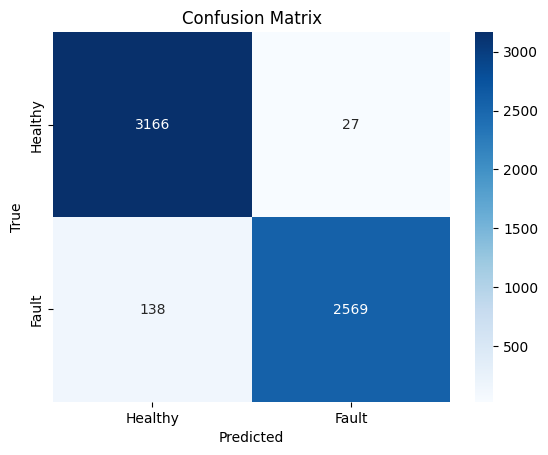

In [36]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy','Fault'], yticklabels=['Healthy','Fault'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()